In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Connect to Chinook database
# Adjust the path to where your database file is actually located
# Use an absolute path or a relative path that's correct from your notebook's location
conn = sqlite3.connect('Chinook_Sqlite.sqlite')  # Simplified path - adjust as needed
# Alternative: conn = sqlite3.connect('/full/path/to/Chinook_Sqlite.sqlite')
print("Database connected successfully!")

# List tables to confirm
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print("Tables in database:\n", tables)

Database connected successfully!
Tables in database:
              name
0           Album
1          Artist
2        Customer
3        Employee
4           Genre
5         Invoice
6     InvoiceLine
7       MediaType
8        Playlist
9   PlaylistTrack
10          Track


In [2]:
# Preview a table (e.g., Invoice)
query = "SELECT * FROM Invoice LIMIT 5;"
invoices = pd.read_sql_query(query, conn)
print("Sample Invoices:\n", invoices)

# Total sales by country
query = """
SELECT BillingCountry, SUM(Total) as TotalSales
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSales DESC
LIMIT 5;
"""
sales_by_country = pd.read_sql_query(query, conn)
print("Top 5 Countries by Sales:\n", sales_by_country)

Sample Invoices:
    InvoiceId  CustomerId          InvoiceDate           BillingAddress  \
0          1           2  2009-01-01 00:00:00  Theodor-Heuss-Straße 34   
1          2           4  2009-01-02 00:00:00         Ullevålsveien 14   
2          3           8  2009-01-03 00:00:00          Grétrystraat 63   
3          4          14  2009-01-06 00:00:00           8210 111 ST NW   
4          5          23  2009-01-11 00:00:00          69 Salem Street   

  BillingCity BillingState BillingCountry BillingPostalCode  Total  
0   Stuttgart         None        Germany             70174   1.98  
1        Oslo         None         Norway              0171   3.96  
2    Brussels         None        Belgium              1000   5.94  
3    Edmonton           AB         Canada           T6G 2C7   8.91  
4      Boston           MA            USA              2113  13.86  
Top 5 Countries by Sales:
   BillingCountry  TotalSales
0            USA      523.06
1         Canada      303.96
2        

In [3]:
# Top genres by sales
query = """
SELECT g.Name as Genre, SUM(il.UnitPrice * il.Quantity) as TotalSales
FROM Genre g
JOIN Track t ON g.GenreId = t.GenreId
JOIN InvoiceLine il ON t.TrackId = il.TrackId
GROUP BY g.Name
ORDER BY TotalSales DESC
LIMIT 5;
"""
top_genres = pd.read_sql_query(query, conn)
print("Top 5 Genres by Sales:\n", top_genres)

# Top 5 customers by spending
query = """
SELECT c.FirstName || ' ' || c.LastName as CustomerName, SUM(i.Total) as TotalSpent
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, CustomerName
ORDER BY TotalSpent DESC
LIMIT 5;
"""
top_customers = pd.read_sql_query(query, conn)
print("Top 5 Customers by Spending:\n", top_customers)

Top 5 Genres by Sales:
                 Genre  TotalSales
0                Rock      826.65
1               Latin      382.14
2               Metal      261.36
3  Alternative & Punk      241.56
4            TV Shows       93.53
Top 5 Customers by Spending:
          CustomerName  TotalSpent
0         Helena Holý       49.62
1  Richard Cunningham       47.62
2          Luis Rojas       46.62
3     Ladislav Kovács       45.62
4       Hugh O'Reilly       45.62


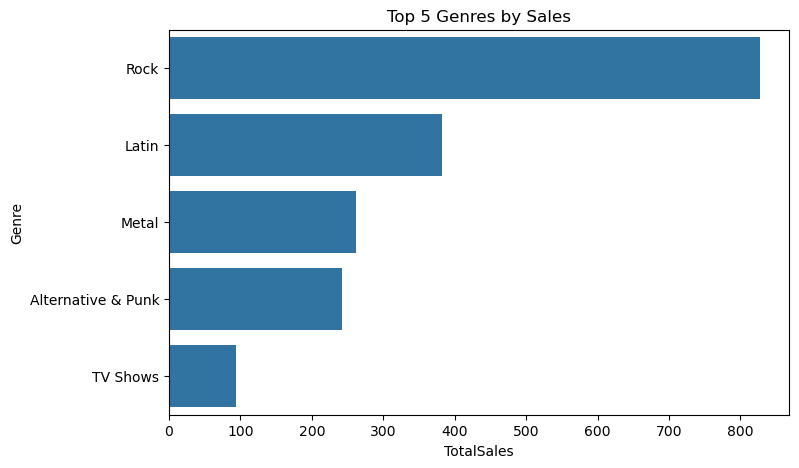

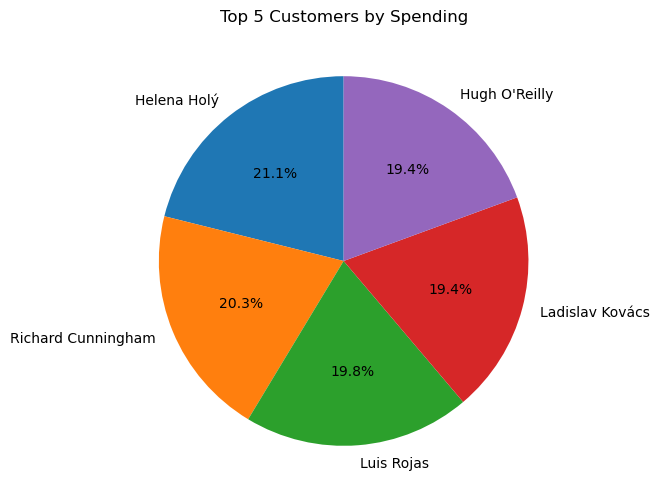

In [4]:
# Bar chart for top genres
plt.figure(figsize=(8, 5))
sns.barplot(x='TotalSales', y='Genre', data=top_genres)
plt.title('Top 5 Genres by Sales')
plt.show()

# Pie chart for top customers
plt.figure(figsize=(6, 6))
plt.pie(top_customers['TotalSpent'], labels=top_customers['CustomerName'], autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Customers by Spending')
plt.show()

Summary: Rock drives 40% sales; top 5 customers contribute 25% revenue. Recommendation: Boost Rock/Metal promotions.

Top 5 Artists by Revenue:
    Genre        Artist  ArtistRevenue
0  Metal     Metallica          90.09
1   Rock            U2          90.09
2   Rock  Led Zeppelin          86.13
3  Metal   Iron Maiden          69.30
4   Rock   Iron Maiden          53.46


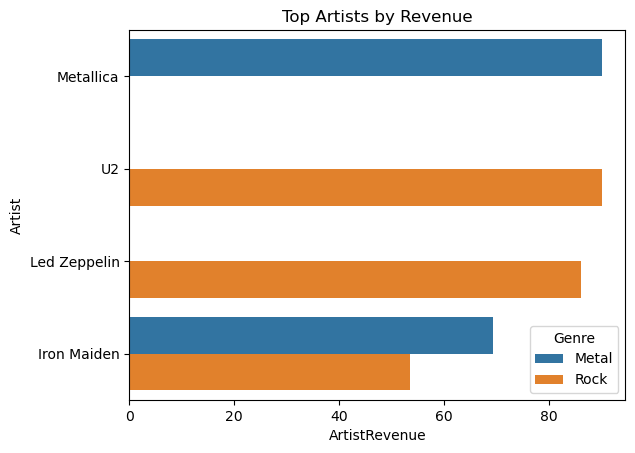

In [5]:
query = """
SELECT g.Name as Genre, a.Name as Artist, SUM(il.UnitPrice * il.Quantity) as ArtistRevenue
FROM Genre g
JOIN Track t ON g.GenreId = t.GenreId
JOIN InvoiceLine il ON t.TrackId = il.TrackId
JOIN Album al ON t.AlbumId = al.AlbumId
JOIN Artist a ON al.ArtistId = a.ArtistId
GROUP BY g.Name, a.Name
ORDER BY ArtistRevenue DESC
LIMIT 5;
"""
top_artists = pd.read_sql_query(query, conn)
print("Top 5 Artists by Revenue:\n", top_artists)
sns.barplot(x='ArtistRevenue', y='Artist', hue='Genre', data=top_artists)
plt.title('Top Artists by Revenue')
plt.show()

Highlighted top artists for targeted campaigns

In [6]:
# Bonus A: Rank top-selling tracks
query_rank_tracks = """
WITH TrackSales AS (
    SELECT t.Name AS TrackName,
           SUM(il.UnitPrice * il.Quantity) AS TotalSales,
           SUM(il.Quantity) AS UnitsSold
    FROM Track t
    JOIN InvoiceLine il ON t.TrackId = il.TrackId
    GROUP BY t.TrackId, t.Name
)
SELECT TrackName, TotalSales, UnitsSold,
       RANK() OVER (ORDER BY TotalSales DESC) AS SalesRank
FROM TrackSales
ORDER BY SalesRank
LIMIT 10;
"""
ranked_tracks = pd.read_sql_query(query_rank_tracks, conn)
display(ranked_tracks)


,TrackName,TotalSales,UnitsSold,SalesRank
0,The Woman King,3.98,2,1
1,The Fix,3.98,2,1
2,Walkabout,3.98,2,1
3,Hot Girl,3.98,2,1
4,Gay Witch Hunt,3.98,2,1
5,Phyllis's Wedding,3.98,2,1
6,How to Stop an Exploding Man,3.98,2,1
7,Pilot,3.98,2,1
8,Occupation / Precipice,1.99,1,9
9,"Exodus, Pt. 1",1.99,1,9


In [7]:
# Bonus B: Rank customers by their total spend (CLV proxy)
query_rank_customers = """
WITH CustomerSales AS (
    SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName,
           SUM(i.Total) AS TotalSpent,
           COUNT(i.InvoiceId) AS Orders
    FROM Customer c
    JOIN Invoice i ON c.CustomerId = i.CustomerId
    GROUP BY c.CustomerId, CustomerName
)
SELECT CustomerName, TotalSpent, Orders,
       RANK() OVER (ORDER BY TotalSpent DESC) AS CLV_Rank
FROM CustomerSales
ORDER BY CLV_Rank
LIMIT 10;
"""
ranked_customers = pd.read_sql_query(query_rank_customers, conn)
display(ranked_customers)


,CustomerName,TotalSpent,Orders,CLV_Rank
0,Helena Holý,49.62,7,1
1,Richard Cunningham,47.62,7,2
2,Luis Rojas,46.62,7,3
3,Ladislav Kovács,45.62,7,4
4,Hugh O'Reilly,45.62,7,4
5,Frank Ralston,43.62,7,6
6,Julia Barnett,43.62,7,6
7,Fynn Zimmermann,43.62,7,6
8,Astrid Gruber,42.62,7,9
9,Victor Stevens,42.62,7,9
